In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
#pm.help()
#pm.reset()
pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
df_jall = pm.df('df_jall')
#df_jo.info()
#df_jall.info()

#df = pm.sort("df_jo", ["id_cr"]).reset_index()
#df = df.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df.copy()
#display(df_jo_cp)

In [3]:
df = pm.df('df_jall')
#display(df)
#display(df[~df.Mes_created_at.isna()])
#df.info()
df['to_recive'] = df.cash_request_received_date-df.created_at
df['to_reimbur'] = df.reimbursement_date-df.created_at
df['to_end'] = df.reimbursement_date-df.money_back_date
df['to_send'] = df.send_at-df.created_at

cr_id = ['id_cr','id_y','user_id','amount','fee','stat_cr','stat_fe','transfer_type','type',
            'to_recive','to_reimbur','to_end','to_send',
            'created_at','reimbursement_date','cash_request_received_date','send_at','money_back_date',
            'paid_at','charge_moment','moderated_at'] # ,'from_date','to_date','reason','recovery_status'


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32094 non-null  int64          
 1   amount                      32094 non-null  float64        
 2   stat_cr                     32094 non-null  object         
 3   created_at                  32094 non-null  datetime64[ns] 
 4   updated_at_x                32094 non-null  datetime64[ns] 
 5   user_id                     32094 non-null  int64          
 6   active                      32094 non-null  int64          
 7   moderated_at                21759 non-null  datetime64[ns] 
 8   reimbursement_date          32094 non-null  datetime64[ns] 
 9   cash_request_received_date  24149 non-null  datetime64[ns] 
 10  money_back_date             23917 non-null  datetime64[ns] 
 11  transfer_type               32094 non-nul

Matriz correlación (Pearson) para variables numéricas del df_jall

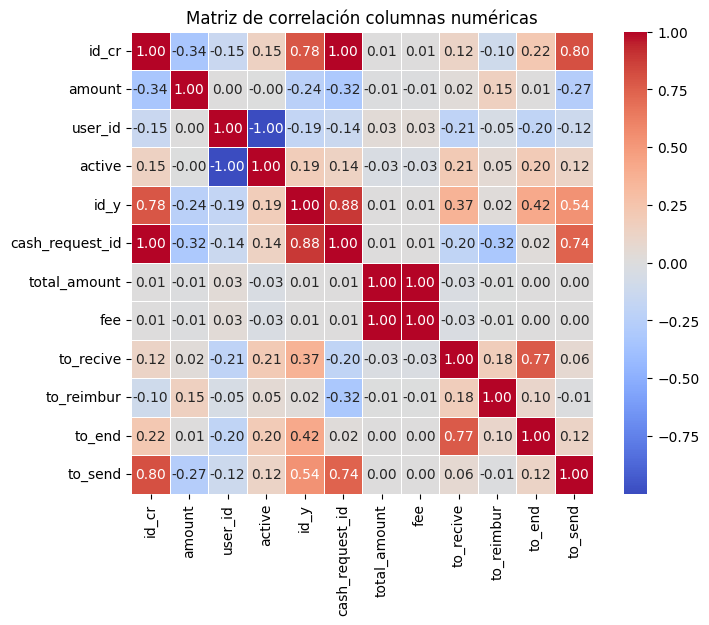

In [20]:
df_corr = df.select_dtypes(include=['number'])  # Mantiene solo columnas numéricas
matriz_corr = df_corr.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación columnas numéricas')
plt.show()

Matriz de correlacion (Pearson) para variables numericas del df_jo

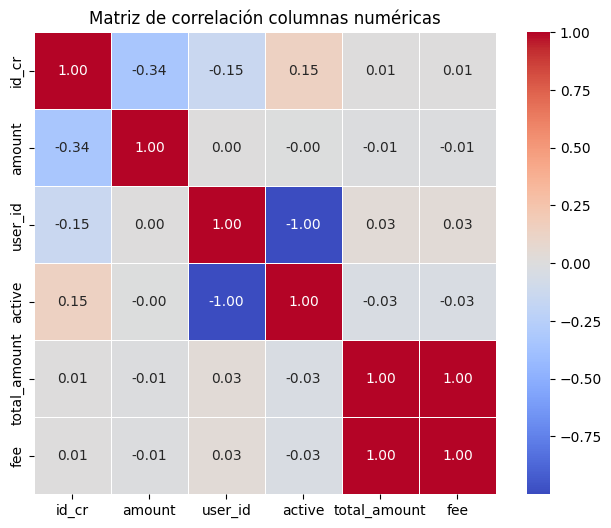

In [21]:
df_corr2 = df_jo.select_dtypes(include=['number'])  # Mantiene solo columnas numéricas
matriz_corr2 = df_corr2.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(matriz_corr2, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación columnas numéricas')
plt.show()

Sabemos que si la relación no es lineal no tendrá sentido.
las fee con el total amount es lineal.
pero la relacion entre el amount y cualquier id no será lineal.

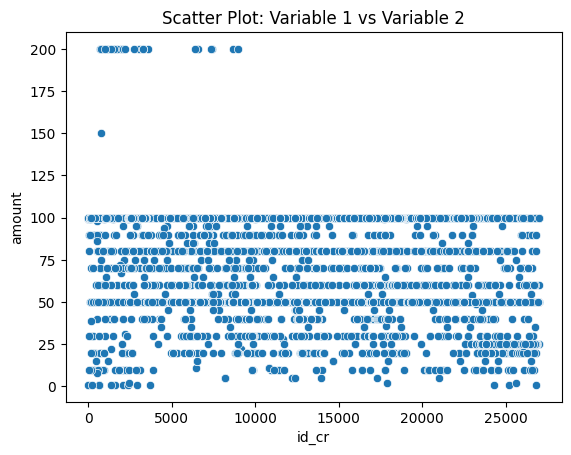

In [36]:
sns.scatterplot(x='id_cr', y='amount', data=df_jall)
plt.title("Scatter Plot: Variable 1 vs Variable 2")
plt.show()


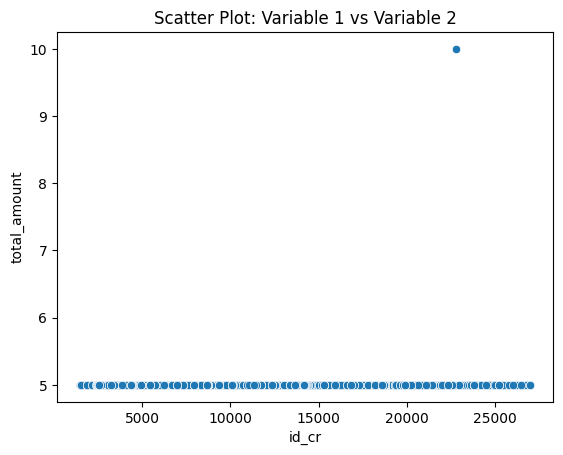

In [43]:
sns.scatterplot(x='id_cr', y='total_amount', data=df_jall)
plt.title("Scatter Plot: Variable 1 vs Variable 2")
plt.show()


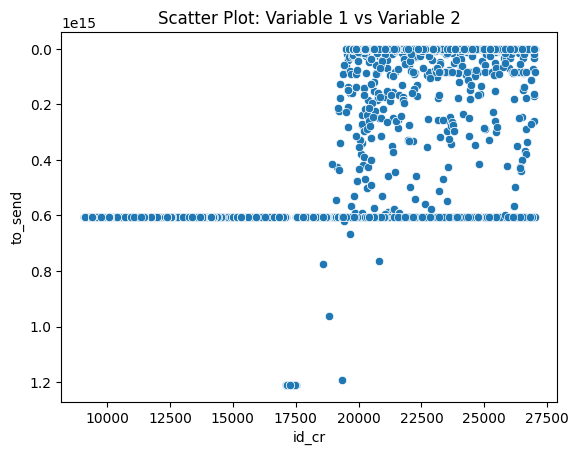

In [45]:
sns.scatterplot(x='id_cr', y='to_send', data=df)
plt.title("Scatter Plot: Variable 1 vs Variable 2")
plt.show()


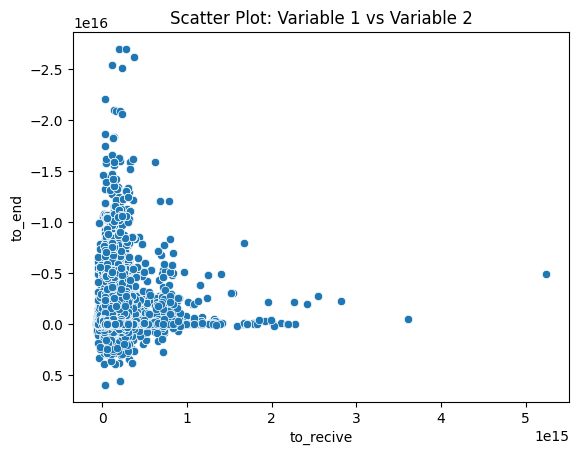

In [50]:
sns.scatterplot(x='to_recive', y='to_end', data=df)
plt.title("Scatter Plot: Variable 1 vs Variable 2")
plt.show()


# analisis estiacionario


In [62]:
# Lista de las columnas que quieres convertir (puedes seleccionar solo las de tipo objeto si no estás seguro)
date_columns = df.select_dtypes(include=['timedelta']).columns  
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_cr                       32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   stat_cr                     32094 non-null  object        
 3   created_at                  32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  datetime64[ns]
 5   user_id                     32094 non-null  int64         
 6   active                      32094 non-null  int64         
 7   moderated_at                21759 non-null  datetime64[ns]
 8   reimbursement_date          32094 non-null  datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             23917 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  object    

In [60]:
#Para poder escoger un número de period que tenga sentido en seasonal_decompose primero vamos a entender qué datos tengoen created_at

# Crear las columnas 'año', 'mes' y 'día'
df['Month'] = df['created_at'].dt.month
df['Day'] = df['created_at'].dt.day
df['year']=df['created_at'].dt.year
# Crear una columna 'dia_semana' que tenga el nombre del día de la semana
df['dia_semana'] = df['created_at'].dt.day_name()

# Ordenar el DataFrame por las columnas 'year' y 'Month'
df_sorted = df.sort_values(by=['year', 'Month', 'created_at'])

# Mostrar las primeras 30 filas de las columnas deseadas
print(df_sorted[['created_at', 'year', 'Month', 'dia_semana']].head(30))


#Ver qué días tengo registros de entrada en mi tabla
df['dia_semana'].unique()

                      created_at  year  Month dia_semana
8778  2019-11-19 13:57:53.511561  2019     11    Tuesday
8013  2019-12-09 14:47:35.190714  2019     12     Monday
0     2019-12-10 19:05:21.596873  2019     12    Tuesday
11860 2019-12-10 19:05:48.921042  2019     12    Tuesday
2     2019-12-10 19:13:35.825460  2019     12    Tuesday
8677  2019-12-10 19:14:41.668754  2019     12    Tuesday
3     2019-12-10 19:16:10.880172  2019     12    Tuesday
10433 2019-12-10 19:18:35.805897  2019     12    Tuesday
4453  2019-12-10 19:18:59.309847  2019     12    Tuesday
8614  2019-12-10 19:22:09.572973  2019     12    Tuesday
8799  2019-12-10 19:22:58.434654  2019     12    Tuesday
8733  2019-12-10 19:29:51.779795  2019     12    Tuesday
10252 2019-12-10 19:29:58.100943  2019     12    Tuesday
7066  2019-12-10 19:34:20.985093  2019     12    Tuesday
1     2019-12-10 19:50:12.347780  2019     12    Tuesday
9     2019-12-10 19:51:23.911206  2019     12    Tuesday
8960  2019-12-10 20:32:59.89640

array(['Tuesday', 'Wednesday', 'Saturday', 'Monday', 'Sunday', 'Thursday',
       'Friday'], dtype=object)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_cr                       32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   stat_cr                     32094 non-null  object        
 3   created_at                  32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  datetime64[ns]
 5   user_id                     32094 non-null  int64         
 6   active                      32094 non-null  int64         
 7   moderated_at                21759 non-null  datetime64[ns]
 8   reimbursement_date          32094 non-null  datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             23917 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  object    

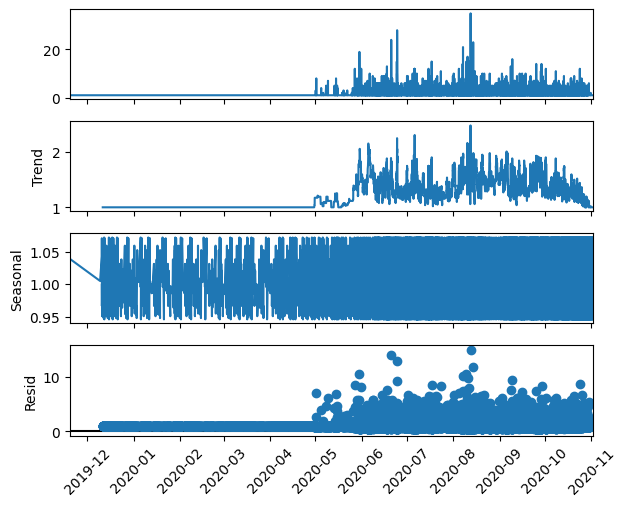

In [ ]:
# 'created_at' sea un tipo datetime
df['created_at'] = pd.to_datetime(df['created_at'])


# Agrupamos los datos y contamos las ocurrencias 
df_decompose = df.groupby('created_at').size()

#  la serie esté ordenada por fecha
df_decompose = df_decompose.sort_index()

# Aplicamos seasonal_decompose
result = seasonal_decompose(df_decompose, model='multiplicative', period=52)  # Periodo 12 para mensual

# Visualizamos los resultados
result.plot()
plt.xticks(rotation=45)
plt.show()


In [11]:
# Descomposición de la serie temporal
descomposicion = seasonal_decompose(cr_cp, model='additive', period=12)

ValueError: could not convert string to float: 'rejected'

In [5]:
# Aplicamos seasonal_decompose
result = seasonal_decompose(fe_cp, model='multiplicative', period=52)  

# Visualizamos los resultados
result.plot()
plt.xticks(rotation=45)
plt.show()

ValueError: could not convert string to float: 'instant_payment'